In [1]:
import argparse
import json
import os
import random
import numpy as np
from pathlib import Path

from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from ignite.metrics import RunningAverage

import torch
from torch import autograd
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [2]:
from utils.handlers import VisPlot, CSVLogger
from networks.paperedge import GlobalWarper, LocalWarper, MaskLoss, WarperUtil, LocalLoss, SupervisedLoss
from data.doc3d import Doc3D, Doc3DDataAug
from data.diw import DIW, DIWDataAug, MixDataset

In [4]:
# parse the experiment configuration
parser = argparse.ArgumentParser()
parser.add_argument("--config", required=True, type=str, help="experiment configuration files.")

# 가져올 학습 하이퍼파라미터
exp_config = parser.parse_args(['--config', 'train.json']).config
print(exp_config) 

with open('configs/' + exp_config, 'r') as fid:
    args = json.load(fid)
print(args)
Path(args['exp_dir']).mkdir(parents=True, exist_ok=True)

# 장치설정
# 다른 모듈 중간중간 cuda으로 옮겨서 고정으로 활용하게하는 
# 코드가 있어서 주의하여야한다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train.json
{'batch_size': 64, 'epochs': 20, 'exp_dir': './chck/', 'lr_G': 1e-05, 'lr_L': 1e-05, 'G_ckpt': './models/G_w_checkpoint_13820.pt', 'L_ckpt': './models/L_w_checkpoint_27640.pt', 'doc3d_root': '# root dir to the doc3d dataset.', 'diw_root': './data/diw', 'vis_port': 10086, 'vis_freq': 100, 'brief': 'demo training'}


In [4]:
# netG == Enet , 경계를 잡아서 사각형으로 보정
# netL == Tnet , 내부정보를 일직선으로 보정
netG = GlobalWarper().to(device)
netL = LocalWarper().to(device)

# 네트워크의 입출력 데이터를 변형하는데 활용
warpUtil = WarperUtil(64).to(device)

# 손실함수
spvLoss = SupervisedLoss().to(device)
local_loss = LocalLoss()

# 마스크 손실함수 
# doc3d의 데이터, x,y, ground-truth 이미지가 있을때
# x는 와핑하고, gt는 언와핑하여 이 둘을 결과를 비교하여 손실함수계산
# 적절한 d_E(변형필드)를 만들도록 네트워크가중치를 최적화할것임
# 아래 이미지 참고
mask_loss = MaskLoss(64)

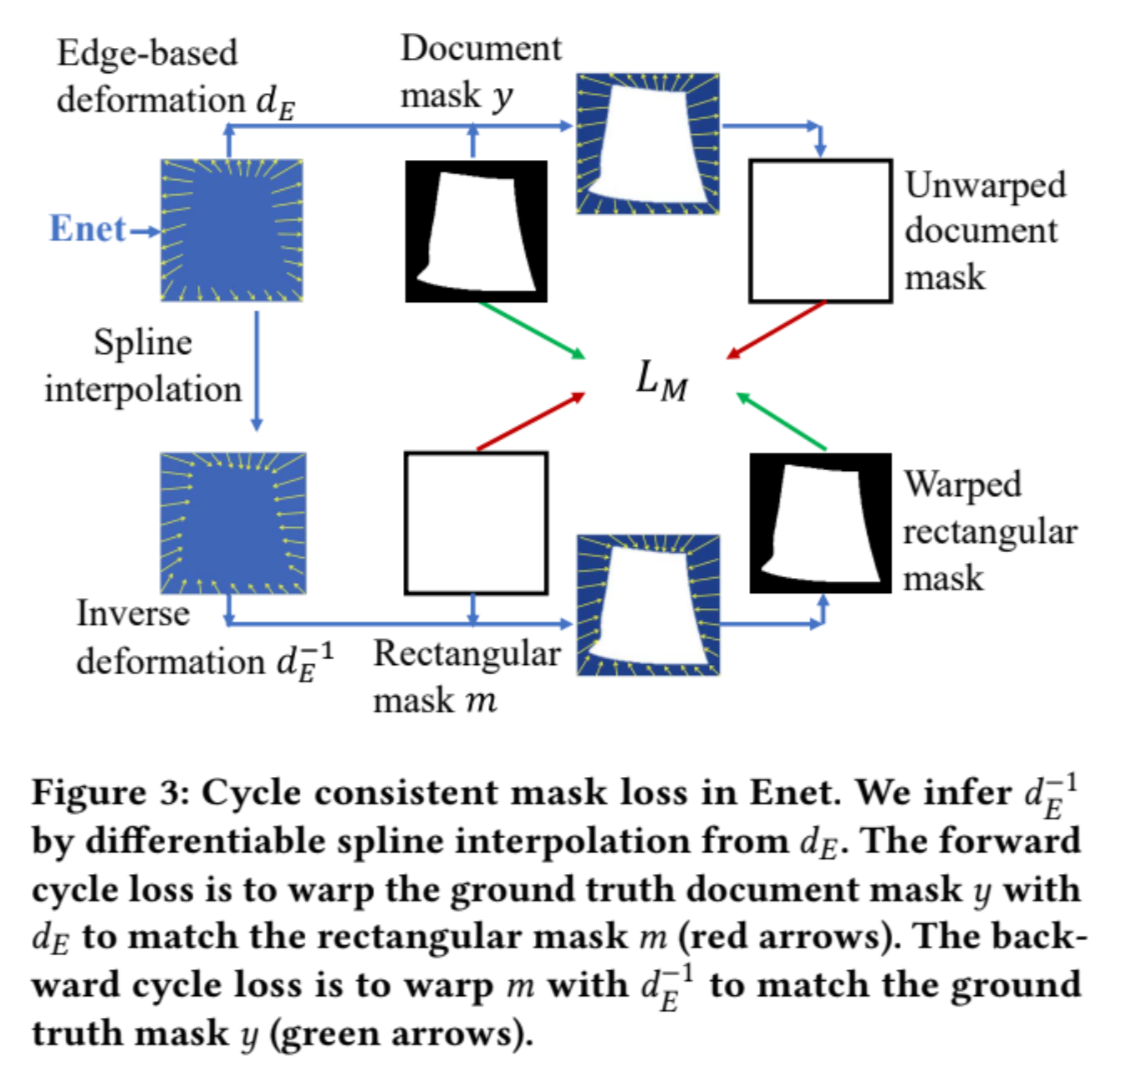

In [5]:
# 가중치 확인 
# 우리는 일단 Enet을 diw데이터(실제사진&마스크)를 파인튜닝해볼것
# doc3d와 학습방법이 다르기때문에 이걸이해하는것이 어렵다
# diw 는 ground-truth 이미지없이 x,y를 가지고 학습 시키는 것이기 때문에 
# 손실함수도 코드를 잘파악해서 수정해서 사용해야한다
torch.load(args['G_ckpt'], map_location=device)['G']
# torch.load(args['L_ckpt'], map_location=device)['L']

OrderedDict([('encoder.0.weight',
              tensor([[[[-1.6578e-03,  9.1907e-02,  2.7508e-02,  ...,  2.8837e-02,
                          3.3489e-02, -3.0509e-02],
                        [ 5.7676e-02,  1.6519e-02,  5.8030e-03,  ...,  8.5892e-02,
                          9.4227e-02, -5.0860e-03],
                        [ 1.1045e-02, -3.0812e-02, -1.4275e-02,  ...,  3.5607e-02,
                          1.1549e-02,  5.0667e-02],
                        ...,
                        [ 5.7598e-03,  2.9009e-02, -2.3963e-02,  ..., -3.3632e-02,
                         -2.1979e-02,  1.0238e-02],
                        [-5.3198e-02, -2.3317e-02, -7.8269e-03,  ..., -3.7558e-02,
                         -3.4669e-02, -4.1027e-02],
                        [-2.9546e-02,  8.4147e-03,  1.5934e-02,  ..., -8.4212e-02,
                         -1.1817e-01, -5.6139e-02]],
              
                       [[ 6.3956e-02,  5.3784e-02,  1.0970e-01,  ...,  2.1574e-02,
                          5.

In [6]:
# 체크포인트 로드
checkpoint = torch.load(args['G_ckpt'], map_location=device)

# 체크포인트 파일의 전체 키와 값 확인
for key, value in checkpoint.items():
    print(f"Key: {key}")
    
    
# 내부사전 불러오기
netG.load_state_dict(torch.load(args['G_ckpt'], map_location=device)['G'])
# 학습모드로 바꾸기, 구조확인
netG.train()

netL.load_state_dict(torch.load(args['L_ckpt'], map_location=device)['L'])
netL.train()


Key: G
Key: L


LocalWarper(
  (encoder): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (actv): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 256, kernel_si

In [7]:
# 옵티마이저 설정
# Adam: 특히나 불규칙한 데이터분포나 불안정한 손실함수일때 유용함
# 모델의 가중치를 최적화하기위해 가져온다, 학습률 1e-5로 
optimizer_G = Adam(netG.parameters(), lr=args['lr_G'])
optimizer_L = Adam(netL.parameters(), lr=args['lr_L'])

# 스케줄러 설정
# StepLR: 한 스텝마다 일정한 비율로 학습률을 감소시킴
# scheduler_G = StepLR(optimizer_G, 5, 0.1)
# scheduler_L = StepLR(optimizer_L, 5, 0.1)

# ReduceLROnPlateau: 모니터링하는 지표가 개선되지않을때 학습률을 감소시킴 
scheduler_G = ReduceLROnPlateau(optimizer_G, factor=0.1, patience=2, verbose=True)
scheduler_L = ReduceLROnPlateau(optimizer_L, factor=0.1, patience=2, verbose=True)

In [8]:
# 데이터셋 경로 확인
# print(args)
print(args['diw_root'])

./data/diw


In [9]:
# 데이터로더 생성
trn_loader = DataLoader(DIW(root_dir=args['diw_root']), batch_size=args['batch_size'], shuffle=True, num_workers=8, pin_memory=True)
# trn_loader = DataLoader(MixDataset(Doc3D(root_dir=args['doc3d_root']), DIW(root_dir=args['diw_root'])), batch_size=args['batch_size'], shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(Doc3D(root_dir=args['doc3d_root'], is_train=False), batch_size=args['batch_size'], num_workers=8, pin_memory=True)

doc3d_aug = Doc3DDataAug()
diw_aug = DIWDataAug()

model_id = 'demo'


In [10]:
'''
모델학습이 단계별로 있다. 
순서:
1. netG를 doc3d데이터(x,y,gt)로 지도학습 한다, L_se 손실함수
2. netG를 doc3d와 diw데이터(x,y)로 약한 지도학습을 한다,  
    L_se + (0.1)L_m의 혼합된 손실함수사용
3. netL도 위와 동일 이하 생략

이때 우리는 2번째에서 diw만 가지고 전이학습(파인튜닝)을 할수있도록 수정해야한다.
'''


# training step with a "_s" postfix is for supervised training with doc3d data.
# training step with a "_w" postfix is for weakly supervised training with both
# doc3d and diw data.

def train_G_step_s(engine, batch):
    netG.train()
    im, fm, bm, bg = batch
    im = im.to(device)
    fm = fm.to(device)
    bm = bm.to(device)
    bg = bg.to(device)
    with torch.no_grad():
        x, y = doc3d_aug(im, fm, bm, bg)
    netG.zero_grad()
    d = netG(x)
    loss = spvLoss.gloss(d, y)
    loss.backward()
    optimizer_G.step()
    dd = warpUtil.global_post_warp(d, 64)
    d = F.interpolate(dd, size=256, mode='bilinear', align_corners=True)
    fake_x = F.grid_sample(x, d.permute(0, 2, 3, 1), align_corners=True).detach()
    engine.state.img = [x, fake_x]
    return {'loss_G': loss.item()}

def validate_G_step_s(engine, batch):
    netG.eval()
    im, fm, bm, bg = batch
    im = im.to(device)
    fm = fm.to(device)
    bm = bm.to(device)
    bg = bg.to(device)
    with torch.no_grad():
        x, y = doc3d_aug(im, fm, bm, bg)
        d = netG(x)
        loss = spvLoss.gloss(d, y)
        engine.state.val_loss += loss.item()
        return {'loss_G': loss.item()}

def train_L_step_s(engine, batch):
    netL.train()
    im, fm, bm, bg = batch
    im = im.to(device)
    fm = fm.to(device)
    bm = bm.to(device)
    bg = bg.to(device)
    with torch.no_grad():
        x, y = doc3d_aug(im, fm, bm, bg)
    # pass the global warp net
        netG.eval()
        dg = netG(x)
        dg = warpUtil.global_post_warp(dg, 64)
        gs = F.interpolate(dg, 256, mode='bilinear', align_corners=True)
        xg = F.grid_sample(x, gs.permute(0, 2, 3, 1), align_corners=True)
    netL.zero_grad()
    xd = netL(xg)
    loss, _ = spvLoss.lloss(xd, y, dg)
    loss.backward()
    optimizer_L.step()
    fake_x = F.grid_sample(xg, F.interpolate(xd, 256, mode='bilinear', align_corners=True).permute(0, 2, 3, 1), align_corners=True)
    engine.state.img = [x, xg.detach(), fake_x.detach()]
    return {'loss_L': loss.item()}

def validate_L_step_s(engine, batch):
    im, fm, bm, bg = batch
    im = im.to(device)
    fm = fm.to(device)
    bm = bm.to(device)
    bg = bg.to(device)
    with torch.no_grad():
        x, y = doc3d_aug(im, fm, bm, bg)
        netG.eval()
        netL.eval()
        dg = netG(x)
        dg = warpUtil.global_post_warp(dg, 64)
        gs = F.interpolate(dg, 256, mode='bilinear', align_corners=True)
        xg = F.grid_sample(x, gs.permute(0, 2, 3, 1), align_corners=True)
        xd = netL(xg)
        loss, _ = spvLoss.lloss(xd, y, dg)
        engine.state.val_loss += loss.item()
        return {'loss_L': loss.item()}

def train_G_step_w(engine, batch):
    # doc3d data
    # loss0 = train_G_step_s(engine, batch[0])['loss_G']
    
    # diw data
    x, xm = batch[1]
    # 배경이미지를 받는것에 오류가있다
    # x, xm, bg= batch[1]
    x = x.to(device)
    xm = xm.to(device)
    
    #증강 생략
    # bg = bg.to(device)
    with torch.no_grad():
        # x, xm = diw_aug(x, xm, bg)
        x, xm = diw_aug(x, xm)
    
    netG.zero_grad()
    # 입력 데이터 x가 [batch_size, 3, height, width] 형태라고 가정
    # 2개의 채널을 추가하여 채널 수를 5로 만듦
    additional_channels = torch.zeros(x.size(0), 2, x.size(2), x.size(3)).to(x.device)
    x = torch.cat([x, additional_channels], dim=1)
    
    d = netG(x)
    dd = F.interpolate(d, 64, mode='bilinear', align_corners=True)
    loss1, _ = mask_loss(dd, xm, 64) # 이게 L_m
    # weight
    loss1 *= 0.1
    loss1.backward()
    optimizer_G.step()
    dd = warpUtil.global_post_warp(d, 64)
    d = F.interpolate(dd, size=256, mode='bilinear', align_corners=True)
    fake_x = F.grid_sample(x, d.permute(0, 2, 3, 1), align_corners=True).detach()
    engine.state.img = [x, fake_x, xm]
    # loss0는 그냥 넣어둔 숫자임
    return {'loss0': 1, 'loss1': loss1.item()}

def train_L_step_w(engine, batch):
    # doc3d data
    netL.train()
    im, fm, bm, bg = batch[0]
    im = im.to(device)
    fm = fm.to(device)
    bm = bm.to(device)
    bg = bg.to(device)
    with torch.no_grad():
        x, y = doc3d_aug(im, fm, bm, bg)
    # pass the global warp net
        netG.eval()
        dg = netG(x)
        dg = warpUtil.global_post_warp(dg, 64)
        gs = F.interpolate(dg, 256, mode='bilinear', align_corners=True)
        xg = F.grid_sample(x, gs.permute(0, 2, 3, 1), align_corners=True)
    netL.zero_grad()
    xd = netL(xg)
    loss0, xdh = spvLoss.lloss(xd, y, dg)
    loss0.backward()
    optimizer_L.step()

    # diw data
    x, xm, bg = batch[1]
    x = x.to(device)
    xm = xm.to(device)
    bg = bg.to(device)
    with torch.no_grad():
        x, xm = diw_aug(x, xm, bg)
        netG.eval()
        dg = netG(x)
        dg = warpUtil.global_post_warp(dg, 64)
        gs = F.interpolate(dg, 256, mode='bilinear', align_corners=True)
        x = F.grid_sample(x, gs.permute(0, 2, 3, 1), align_corners=True)
    # generate warp
    tgs, invtgs = warpUtil.perturb_warp(xdh)
    xp = F.grid_sample(x, F.interpolate(tgs, 256, mode='bilinear', align_corners=True).permute(0, 2, 3, 1), align_corners=True)
    netL.zero_grad()
    xd = netL(x)
    xpd = netL(xp.detach())
    loss1 = local_loss.warp_diff_loss(xd, xpd, tgs.detach(), invtgs.detach())
    loss1 *= 0.1
    loss1.backward()
    optimizer_L.step()
    fake_x = F.grid_sample(x, F.interpolate(xd, 256, mode='bilinear', align_corners=True).permute(0, 2, 3, 1), align_corners=True)
    fake_xp = F.grid_sample(xp, F.interpolate(xpd, 256, mode='bilinear', align_corners=True).permute(0, 2, 3, 1), align_corners=True)
    engine.state.img = [x.detach(), xp.detach(), fake_x.detach(), fake_xp.detach()]
    return {'loss0': loss0, 'loss1': loss1.item()}


In [11]:
# 학습 순서 선택
# trainer = Engine(train_G_step_s)
# trainer = Engine(train_L_step_s)
trainer = Engine(train_G_step_w)
# trainer = Engine(train_L_step_w)

# 메트릭(성능지표) 초기값 설정
# 파인튜닝이기때문에 설정할지말지 테스트해야뎀
trainer.state.metrics['loss_val'] = 0

# validator = Engine(validate_G_step_s)
# validator = Engine(validate_L_step_s)
# @trainer.on(Events.EPOCH_COMPLETED)
# def validate(engine):
#     validator.state.val_loss = 0
#     validator.run(val_loader)
#     val_loss = validator.state.val_loss / len(val_loader)
#     trainer.state.metrics['loss_val'] = val_loss
#     print(f'Validation loss: {val_loss}')
    
@trainer.on(Events.EPOCH_COMPLETED)
def update_lr(engine):
    scheduler_G.step(engine.state.metrics['loss_val'])
    # scheduler_L.step(engine.state.metrics['loss_val'])

# RunningAverage(alpha=0.9, output_transform=lambda x: x['loss_G']).attach(trainer, 'loss_G')
# RunningAverage(alpha=0.9, output_transform=lambda x: x['loss_L']).attach(trainer, 'loss_L')
RunningAverage(alpha=0.9, output_transform=lambda x: x['loss0']).attach(trainer, 'loss0')
RunningAverage(alpha=0.9, output_transform=lambda x: x['loss1']).attach(trainer, 'loss1')


# monitoring_metrics = ['loss_G']
# monitoring_metrics = ['loss_L']
monitoring_metrics = ['loss0', 'loss1']

In [12]:

# model checkpoint
ckpt_hdl = ModelCheckpoint(args['exp_dir'], model_id, n_saved=1, require_empty=False, score_function=lambda x: -x.state.metrics['loss_val'])
# ckpt_hdl = ModelCheckpoint(args['exp_dir'], model_id, n_saved=3, require_empty=False)
# test on same images
vis_plot = VisPlot(port=args['vis_port'], env='gnet')
# attach progress bar
pbar = ProgressBar(persist=True)
pbar.attach(trainer, metric_names=monitoring_metrics)
# vpbar = ProgressBar()
# vpbar.attach(validator)
# log csv
csv_logger = CSVLogger(os.path.join(args['exp_dir'], 'log_' + model_id + '.csv'))

trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), ckpt_hdl, {'G': netG, 'L': netL})
# trainer.add_event_handler(Events.EPOCH_COMPLETED, tst_vis())

Setting up a new session...
c:\Users\82105\Desktop\book_scan\rcf_env\Lib\site-packages\ignite\contrib\handlers\tqdm_logger.py:126: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [13]:
# vis
@trainer.on(Events.ITERATION_COMPLETED(every=args['vis_freq']))
def plot_input_output():
    for ii in range(len(trainer.state.img)):
        vis_plot.plot_imgs(trainer.state.img[ii][:min(16, args['batch_size'])].cpu().numpy(), win=f'img{ii}')
    # # plot mesh
    # tt = trainer.state.img[-1][:2].permute(0, 2, 3, 1).detach().cpu().numpy()
    # vis_plot.plot_meshes(tt, win='mesh1')
    # tt = trainer.state.img[-1][:2].permute(0, 2, 3, 1).detach().cpu().numpy()
    # vis_plot.plot_meshes(tt, win='mesh2')
    # fig, axs = plt.subplots(1, 8)
    # tt = trainer.state.img[-1][:8].permute(0, 2, 3, 1).detach().cpu().numpy()
    # plt.clf()
    # for ii in range(8):
    #     t = tt[ii]
    #     axs[ii].pcolormesh(t[..., 0], t[..., 1], np.zeros_like(t[..., 0]), edgecolors='r')
    #     axs[ii].invert_yaxis()
    #     axs[ii].axis('equal')
    # vis.matplot(plt, env='gnet', win='mpl')

In [14]:
trainer.add_event_handler(Events.ITERATION_COMPLETED(every=args['vis_freq']), vis_plot.plot_loss, monitoring_metrics)
trainer.add_event_handler(Events.ITERATION_COMPLETED(every=args['vis_freq']), csv_logger, monitoring_metrics)

trainer.run(trn_loader, max_epochs=args['epochs'])

Epoch [1/20]: [1/1] 100%|██████████, loss0=1, loss1=0.118 [00:00<?]
Epoch [2/20]: [1/1] 100%|██████████, loss0=1, loss1=0.118 [00:00<?]
Epoch [3/20]: [1/1] 100%|██████████, loss0=1, loss1=0.117 [00:00<?]
Epoch [4/20]: [1/1] 100%|██████████, loss0=1, loss1=0.115 [00:00<?]


Epoch 00004: reducing learning rate of group 0 to 1.0000e-06.


Epoch [5/20]: [1/1] 100%|██████████, loss0=1, loss1=0.114 [00:00<?]
Epoch [6/20]: [1/1] 100%|██████████, loss0=1, loss1=0.113 [00:00<?]
Epoch [7/20]: [1/1] 100%|██████████, loss0=1, loss1=0.111 [00:00<?]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-07.


Epoch [8/20]: [1/1] 100%|██████████, loss0=1, loss1=0.11 [00:00<?]
Epoch [9/20]: [1/1] 100%|██████████, loss0=1, loss1=0.108 [00:00<?]
Epoch [10/20]: [1/1] 100%|██████████, loss0=1, loss1=0.108 [00:00<?]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-08.


Epoch [11/20]: [1/1] 100%|██████████, loss0=1, loss1=0.107 [00:00<?]
Epoch [12/20]: [1/1] 100%|██████████, loss0=1, loss1=0.106 [00:00<?]
Epoch [13/20]: [1/1] 100%|██████████, loss0=1, loss1=0.105 [00:00<?]
Epoch [14/20]: [1/1] 100%|██████████, loss0=1, loss1=0.104 [00:00<?]
Epoch [15/20]: [1/1] 100%|██████████, loss0=1, loss1=0.104 [00:00<?]
Epoch [16/20]: [1/1] 100%|██████████, loss0=1, loss1=0.104 [00:00<?]
Epoch [17/20]: [1/1] 100%|██████████, loss0=1, loss1=0.103 [00:00<?]
Epoch [18/20]: [1/1] 100%|██████████, loss0=1, loss1=0.103 [00:00<?]
Epoch [19/20]: [1/1] 100%|██████████, loss0=1, loss1=0.103 [00:00<?]
Epoch [20/20]: [1/1] 100%|██████████, loss0=1, loss1=0.103 [00:00<?]


State:
	iteration: 20
	epoch: 20
	epoch_length: 1
	max_epochs: 20
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	img: <class 'list'>